# Introduction to TPI tool for the processing of MODIS data

**What does this notebook do?** 
This notebook demonstrates how to use the TPI tool to calculate Topographic Position Index (Weiss, 2001) from MODIS data.
The TPI tool is able to identify the local anomalies on the MODIS data (e.g, ocean currents, upwellings).

Weiss, A.D. (2001). Topographic Position and Landforms Analysis. In, ESRI International User Conference. San Diego, CA

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 19th September, 2018

**Author:** Zhi Huang

### Import modules

**The TPI tool is implemented in the SpatialTools module with two functions: my_mean_filter and calculate_tpi. Please refer to the python scripts for further information.**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import sys
import os
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import SpatialTools

**Specify a development database to connect to. It is on a different database server agdcdev-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dra547/modis_oc.conf')

**Design a query. The area is bounded by 30-40S and 130-150E, which ofen features the Bonney Coast 
upwellign during summer time**

In [3]:
query = {'latitude':(-30,-40),
        'longitude':(130,150),
        'time':('2016-01-01','2016-01-15')}

**Load 15 days of SST (Sea Surface Temperature) and CHL_GSM (Chlorophyll _a_) data from the start of 2016. Note that we want to fetch the data with their original resolution.
This would requires large memory usage.**

In [4]:
data = dc.load(product='modis_oc_1d', resolution=(-0.01, 0.01), measurements=('sst','chl_gsm'),**query)

**Mask the nodata (-999) as 'nan'**

In [5]:
data = mask_invalid_data(data)

In [6]:
data

<xarray.Dataset>
Dimensions:    (latitude: 1000, longitude: 2000, time: 15)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ...
  * latitude   (latitude) float64 -30.0 -30.02 -30.02 -30.04 -30.04 -30.05 ...
  * longitude  (longitude) float64 130.0 130.0 130.0 130.0 130.0 130.1 130.1 ...
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan nan nan nan ...
    chl_gsm    (time, latitude, longitude) float32 nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:4326

**Try merging the data together every 5 days to fill in the gaps**

In [7]:
data2 = data.resample(time='5D').mean()

In [60]:
data2

<xarray.Dataset>
Dimensions:    (latitude: 1000, longitude: 2000, time: 3)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ...
  * latitude   (latitude) float64 -30.0 -30.02 -30.02 -30.04 -30.04 -30.05 ...
  * longitude  (longitude) float64 130.0 130.0 130.0 130.0 130.0 130.1 130.1 ...
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan nan nan nan ...
    chl_gsm    (time, latitude, longitude) float32 nan nan nan nan nan nan ...

**Plot the SST data**

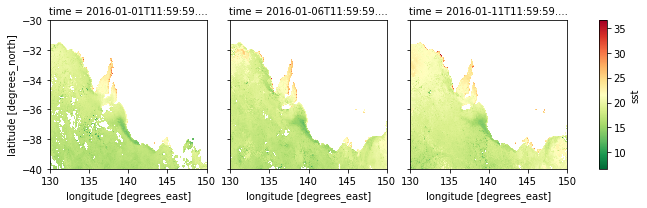

In [10]:
data2.sst.plot(col='time',col_wrap=3,cmap='RdYlGn_r')

**Plot the CHL_GSM data**

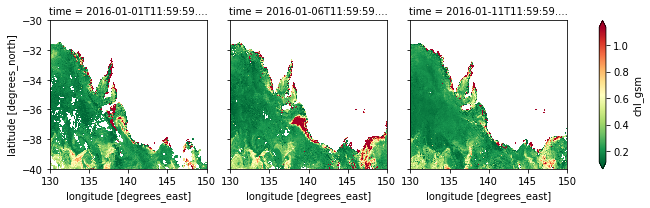

In [12]:
data2.chl_gsm.plot(col='time',col_wrap=3,cmap='RdYlGn_r',robust=True)

**Select the second 5-days composite which shows strong upwelling signatures in SST and CHL_GSM**

In [13]:
data3 = data2.isel(time=1)

In [14]:
data3

<xarray.Dataset>
Dimensions:    (latitude: 1000, longitude: 2000)
Coordinates:
    time       datetime64[ns] 2016-01-06T11:59:59.999999
  * latitude   (latitude) float64 -30.0 -30.02 -30.02 -30.04 -30.04 -30.05 ...
  * longitude  (longitude) float64 130.0 130.0 130.0 130.0 130.0 130.1 130.1 ...
Data variables:
    sst        (latitude, longitude) float32 nan nan nan nan nan nan nan nan ...
    chl_gsm    (latitude, longitude) float32 nan nan nan nan nan nan nan nan ...

**Use the TPI tool (i.e., calculte_tpi function) to calculate TPI values for the SST data.
The neighborhood is a circle with a radius of 50 cells, for example 0.5 dd (or ~50 km) in this case. 
This function returns a xarray.DataArray. Note that this function took about 1 hour 20 mins to complete,
mainly due to the large neighborhood size being used.**

In [15]:
data3_sst_tpi = SpatialTools.calculte_tpi(data3.sst,neighborhood='Circle',radius=50)

**Plot the SST data and the TPI layer derived from it for comparison**

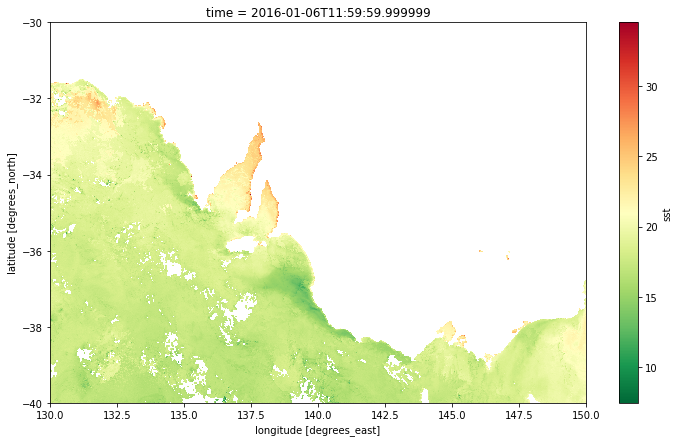

In [23]:
data3.sst.plot(figsize=(12,7),cmap='RdYlGn_r')

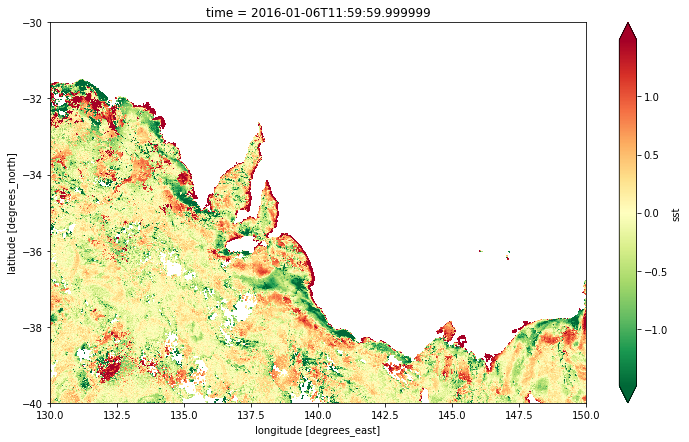

In [21]:
data3_sst_tpi.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

**Use the TPI tool (i.e., calculte_tpi function) to calculate TPI values for the CHL_GSM data.
The neighborhood is a circle with a radius of 50 cells, for example 0.5 dd (or ~50 km) in this case. 
This function returns a xarray.DataArray. Note that this function took about 1 hour 20 mins to complete,
mainly due to the large neighborhood size being used.**

In [24]:
data3_chl_gsm_tpi = SpatialTools.calculte_tpi(data3.chl_gsm,neighborhood='Circle',radius=50)

**Plot the CHL_GSM data using the 'robust' option, which removes outliers from displaying. 
The CHL_GSM contains some extreme high CHL values. In this case, these extremely high values 
have been regarded as outliers and now shown in the figure.**

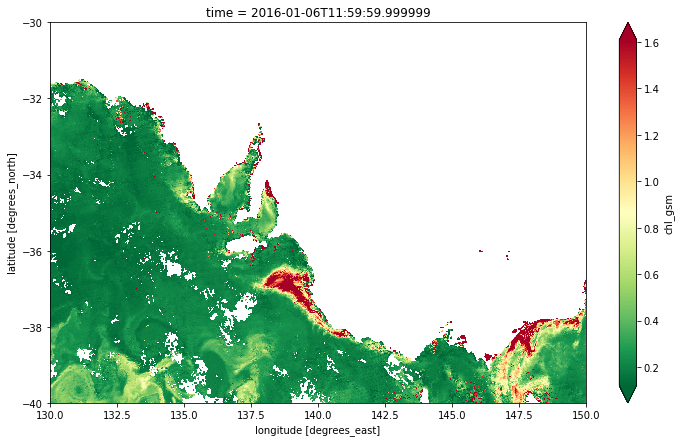

In [29]:
data3.chl_gsm.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

In [54]:
print('max:',data3_chl_gsm_tpi.max())
print('min:',data3_chl_gsm_tpi.min())

max: <xarray.DataArray 'chl_gsm' ()>
array(39652652.)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999
min: <xarray.DataArray 'chl_gsm' ()>
array(-11322.663086)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999


**The same 'robust' option does not work when plotting the TPI layer derived from the CHL_GSM data. This is because the TPI layer not only has extremely high positive values but also has 
extremely high negative values. As such, these extremely high values could not be regarded as outliers.**

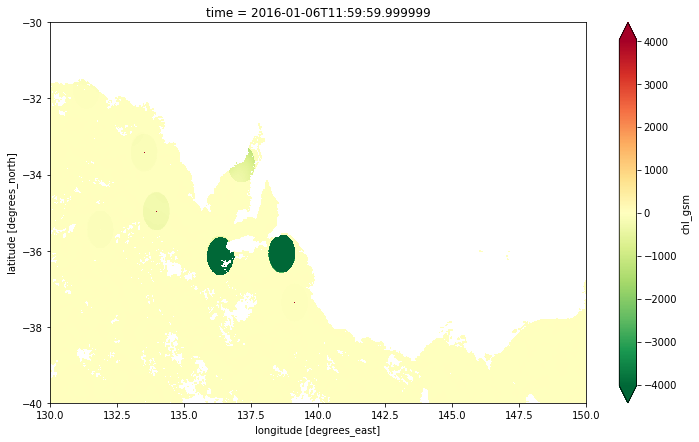

In [30]:
data3_chl_gsm_tpi.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

**To resolve this problem, the extremely high values in CHL_GSM data need to be removed.**

In [34]:
chl_gsm = data3.chl_gsm

In [40]:
chl_gsm = chl_gsm.where(chl_gsm < 10)

In [41]:
chl_gsm = chl_gsm.where(chl_gsm > 0)

**Re-run the TPI tool on the outlier-removed CHL_GSM data**

In [45]:
chl_gsm_tpi = SpatialTools.calculte_tpi(chl_gsm,neighborhood='Circle',radius=50)

**The statistics for the newly derived TPI layer look normal now**

In [55]:
print('max:',chl_gsm_tpi.max())
print('min:',chl_gsm_tpi.min())
print('mean:',chl_gsm_tpi.mean())

max: <xarray.DataArray 'chl_gsm' ()>
array(9.617)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999
min: <xarray.DataArray 'chl_gsm' ()>
array(-4.824066)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999
mean: <xarray.DataArray 'chl_gsm' ()>
array(0.005438)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999


**Plot the CHL_GSM data and the TPI layer derived from it for comparison**

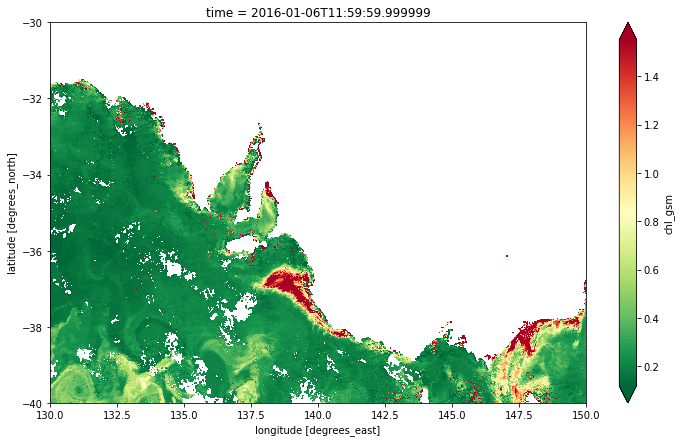

In [49]:
chl_gsm.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

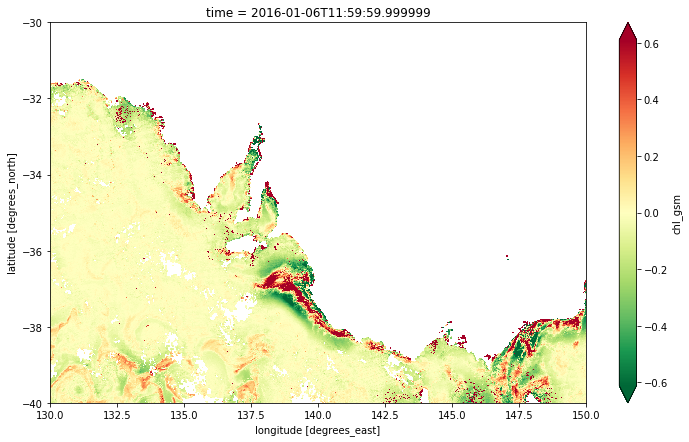

In [50]:
chl_gsm_tpi.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)